# title:        MULAN: A Blind and Off-Grid Method for Multichannel Echo Retrieval

authors:  helena.peic.tukuljac@gmail.com, antoine.deleforge@inria.fr

year:        2018

license:    GPL v3

This notebook contains an example that illustrates the deconvolution of the *on gird* Diracs with a speech signal for the following algorithms:
# a) Cross-relation method
# b) LASSO with h(1) = 1 constriant
- we want to solve:
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \lvert\lvert \mathbf{A} \mathbf{x}\rvert \rvert_2 + \lambda \lvert\lvert\mathbf{x}\rvert\rvert_1 \\
& \text{subject to}
& & \mathbf{x}[1]=1
\end{aligned}
\end{equation*}
- we decompose our optimization variable as: $\mathbf{x} = [1; \mathbf{y}]$
- we decompose our optimization matrix as: $\mathbf{A} = [\mathbf{a}_1; \mathbf{A}_2]$
- now we have an unconstrained LASSO
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \lvert\lvert \mathbf{A}_2 \mathbf{y} + \mathbf{a}_1\rvert \rvert_2 + \lambda \lvert\lvert\mathbf{x}\rvert\rvert_1 \\
\end{aligned}
\end{equation*}

# c) MULAN (MULtichannel ANnihilation)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_retrieval_results(subplot_name, figure_title, x_values_gt, y_values_gt, x_values_ret, y_values_ret):
    (markers, stemlines, baseline) = subplot_name.stem(x_values_gt, y_values_gt, label = "Ground truth")
    subplot_name.setp(markers, marker='o', markersize=20, markeredgecolor="red", markerfacecolor="white", markeredgewidth=3)
    subplot_name.setp(stemlines, 'color', 'red', 'linewidth', '3')
    subplot_name.setp(baseline, 'color', 'black')
    (markers, stemlines, baseline) = subplot_name.stem(x_values_ret, y_values_ret, label = "Retrieval")
    subplot_name.setp(markers, marker='x', markersize=15, markeredgecolor="green", markeredgewidth=3)
    subplot_name.setp(stemlines, 'color', 'green', 'linewidth', '3')
    subplot_name.setp(baseline, 'color', 'black')
    subplot_name.title(figure_title)
    subplot_name.legend(loc = 'upper right')

In [2]:
import numpy as np
from scipy.signal import convolve

from algorithm import InitializationType, mulan
from measurement_tools import generate_artificial_rirs, load_input_signal
from measurement_tools import FilterType, InputSignalType, get_spectral_coefficients
from baseline_methods import LASSO_approach, cross_relations, pick_echoes
from test_tools import get_reconstruction_error

In [3]:
init_option = InitializationType.Random
filter_option = FilterType.Artificial
input_signal_option = InputSignalType.Speech

In [4]:
# input paramteres:
# K, M, x, L, F
file_number = 11
K = 7
M = 2
F = 16000
Ts = 0.5
Fs_low = 16000
filters, alpha, tau = generate_artificial_rirs(M, K, Ts, F) 
mintau = min(tau[:, 0])
tau = tau - mintau
alpha = alpha/alpha[0, 0]

signal = load_input_signal(Ts, F, file_number)
L = filters.shape[0]
Ts = len(signal)/F
Tf = filters.shape[0]/F
print('Signal length %f' % Ts)
print('Filter length %f' % Tf)
time_vector_convolution = np.linspace(1/F, Ts + Tf, len(signal) + filters.shape[0] - 1)
T_total = (len(signal) + filters.shape[0])/F
x = np.zeros((len(time_vector_convolution), M), dtype=np.complex128) 
for k in range(M):
    x[:, k] = convolve(signal, filters[:, k], 'full')
print('Are the echoes on the grid?')
print(tau*F)

[measurement_tools.py: 152 -    load_input_signal() ] Signal file name: 11.wav


Signal length 0.500000
Filter length 0.100000
Are the echoes on the grid?
[[   0.  639.]
 [ 621.  742.]
 [ 640.  937.]
 [1178.  963.]
 [1286. 1010.]
 [1305. 1062.]
 [1483. 1390.]]


In [9]:
####################################### TEMPORAL METHODS #######################################
# METHOD1: cross-relation
print('Cross-relation started!')
h_cr = cross_relations(x,L)
tau_cr, alpha_cr = pick_echoes(h_cr,K)
mintau = min(tau_cr[:, 0])
tau_cr = tau_cr - mintau
alpha_cr = alpha_cr/np.max(alpha_cr)
h_cr = np.concatenate((h_cr[mintau.astype(int):, :], np.zeros((mintau.astype(int),M))), axis = 0)
h_cr = h_cr/alpha_cr[0, 0]
print('Cross-relation done!')

# METHOD2: constrained LASSO
print('LASSO started!')
h_lasso = LASSO_approach(x,L)
tau_lasso, alpha_lasso = pick_echoes(h_lasso,K)
mintau = min(tau_lasso[:, 0])
tau_lasso = tau_lasso - mintau
alpha_lasso = alpha_lasso/alpha_lasso[0, 0]
h_lasso = np.concatenate((h_lasso[mintau.astype(int):, :], np.zeros((mintau.astype(int),M))), axis = 0)
h_lasso = h_lasso/alpha_lasso[0, 0]
print('LASSO done!')

####################################### SPECTRAL METHODS #######################################
# METHOD3: MULAN
print('MULAN started!')
nF = 401
X, sf, f, frequency_offset, frequency_step, T_total = get_spectral_coefficients(signal, K, filters, nF, F)
_, tau_sec_ml, _, alpha_ml, _, _, _, _, _, _ = mulan(X, f, frequency_offset, frequency_step, K, T_total, alpha, \
                                                     tau, init_option, filter_option, input_signal_option, np.zeros((len(f), 1)))
print('MULAN done!')

Cross-relation started!
Cross-relation done!
LASSO started!


c:\users\helena\anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
c:\users\helena\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LASSO done!
MULAN started!


[algorithm.py:  79 -                mulan() ] M = 2 K = 7 nF = 401 - min: 200.00; step: 4.50 [Hz]; max: 2000.00
[algorithm.py: 114 -                mulan() ] Initialization counter: 1 out of 20; objective function: 1.086669e+03
[algorithm.py: 114 -                mulan() ] Initialization counter: 2 out of 20; objective function: 1.295701e+04
[algorithm.py: 114 -                mulan() ] Initialization counter: 3 out of 20; objective function: 6.136896e+02
[algorithm.py: 114 -                mulan() ] Initialization counter: 4 out of 20; objective function: 4.299621e-18
[algorithm.py: 122 -                mulan() ] Lowest objective function value: 4.299621e-18
D:\SWITCHdrive\Inria\MULAN\gforge_code\code\trunk\fri.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `

MULAN done!


In [10]:
# Convert to seconds:
tau_ml = tau_ml*Fs_low
tau_sec_cr = tau_cr/Fs_low
tau_sec_lasso = tau_lasso/Fs_low
et_cr = get_reconstruction_error(M, tau, tau_sec_cr)
et_cl = get_reconstruction_error(M, tau, tau_sec_lasso)
et_ml = get_reconstruction_error(M, tau, tau_sec_ml)
ea_cr = get_reconstruction_error(M, alpha, alpha_cr)
ea_cl = get_reconstruction_error(M, alpha, alpha_lasso)
ea_ml = get_reconstruction_error(M, alpha, alpha_ml)

In [11]:
import pandas as pd

np.random.seed(24)
df_tau = pd.DataFrame({'RMSE on grid': ['locations', 'weights']})
df_tau = pd.concat([df_tau, pd.DataFrame(np.reshape([et_cr, et_cl, et_ml, ea_cr, ea_cl, ea_ml], (2, 3)), columns=['cross-relation', 'constrainted LASSO', 'MULAN'])],
               axis=1)
df_tau.style

,RMSE on grid,cross-relation,constrainted LASSO,MULAN
0,locations,0,0,3.25813e-12
1,weights,0.0616496,0.114675,1.0085e-09


c:\users\helena\anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


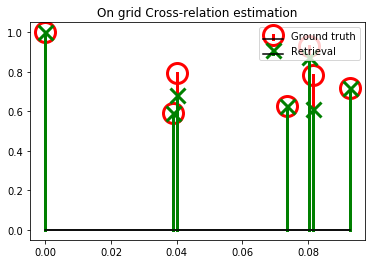

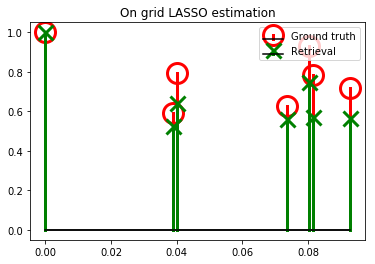

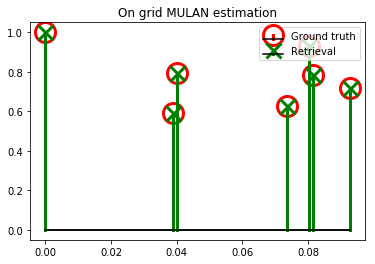

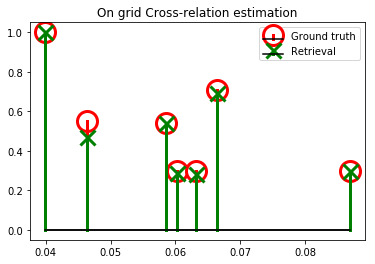

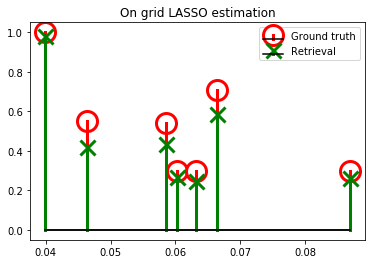

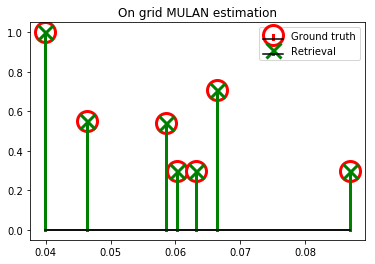

In [13]:
for m in range(2):
    title_cr = 'On grid Cross-relation estimation'
    title_lasso = 'On grid LASSO estimation'
    title_mulan = 'On grid MULAN estimation'
    plt.figure(m*3 + 1)
    visualize_retrieval_results(plt, title_cr, tau[:, m], abs(alpha[:, m]), tau_sec_cr[:, m], (alpha_cr[:,m]))
    plt.figure(m*3 + 2)
    visualize_retrieval_results(plt, title_lasso, tau[:, m], abs(alpha[:, m]), tau_sec_lasso[:, m], abs(alpha_lasso[:,m]))
    plt.figure(m*3 + 3)
    visualize_retrieval_results(plt, title_mulan, tau[:, m], abs(alpha[:, m]), tau_sec_ml[:, m], abs(alpha_ml[:,m]))
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)